In [23]:
import os
import tarfile
import json

resize_w, resize_h = 48, 48
channel = 1

with open ( 'model/model-shapes.json', "w") as shapes:
    json.dump([{"shape": (None, channel, resize_h, resize_w), "name": "data"}], shapes)
    
def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo

tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model", filter=flatten)
tar.close()




In [24]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

In [25]:
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

In [26]:
from sagemaker.mxnet.model import MXNetModel
sagemaker_model = MXNetModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  entry_point = 'resnet.py')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
1.6.0 is the latest version of mxnet that supports Python 2. Newer versions of mxnet will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 mxnet image.
No framework_version specified, defaulting to version 1.2. framework_version will be required in SageMaker Python SDK v2. This is not the latest supported version. If you would like to use version 1.6.0, please add framework_version=1.6.0 to your constructor.


In [27]:
import logging
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                          instance_type='ml.m4.xlarge')


'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!

In [238]:
import cv2 
import numpy as np 
image_size = 48 
src = './case_23.JPG'
img = cv2.imread(src , cv2.IMREAD_GRAYSCALE)
img_org = cv2.imread(src)
print(img.shape)
img = cv2.resize(img, (image_size, image_size))
print(img.shape)


img = img[np.newaxis]
img = img[np.newaxis]
img.shape

(960, 1280)
(48, 48)


(1, 1, 48, 48)

Detection [(399, 194) (861, 657)], score: 0.14733702321184827, face_type:0
(48, 48, 3)
(1, 1, 48, 48, 3)


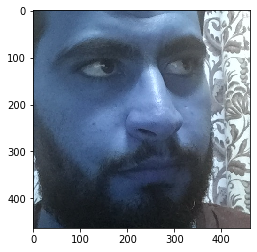

In [246]:
import dlib
detector = dlib.get_frontal_face_detector()
dets, scores, idx  = detector.run(img_org, 1)
for i, d in enumerate(dets):
    print("Detection {}, score: {}, face_type:{}".format(
        d, scores[i], idx[i]))
    crop = img_org[d.top():d.bottom(), d.left():d.right()]
    plt.imshow(crop)
crop = cv2.resize(crop, (image_size, image_size))
print(crop.shape)


crop = crop[np.newaxis]
crop = crop[np.newaxis]
print(crop[:,:,:].shape)

In [221]:
import mxnet as mx
from mxnet import autograd, contrib, gluon, image, init, nd
ctx = mx.cpu()
NEAR_0 = 1e-10
idx_tensor = nd.array([idx for idx in range(1,67)]).as_in_context(ctx)

In [222]:
def stable_softmax(z):
    z = nd.exp(z - nd.max(z, axis=1, keepdims=True))
    return z / mx.nd.sum(z, axis=1).reshape((1, 1))

In [223]:
img.shape
print(pred[0][:66])


[-1.88694918e+00 -1.90512049e+00 -7.92570472e-01  1.60441792e+00
 -8.82794738e-01 -1.42055184e-01 -5.49856484e-01 -3.38108867e-01
 -4.21624869e-01 -1.81340361e+00 -1.96263027e+00  1.87006783e+00
 -2.09223437e+00 -1.88321084e-01  7.36088634e-01 -1.14050770e+00
 -1.89515281e+00 -1.33059368e-01 -9.48710680e-01 -1.90297270e+00
 -2.74324799e+00 -1.10517323e+00 -8.50779861e-02 -2.87593365e+00
 -2.85746694e+00  3.15918595e-01  3.30249369e-02  2.52459019e-01
 -4.25567448e-01 -7.49971271e-02 -1.31025493e+00  1.83249652e-01
 -8.62285376e-01  2.96868235e-01  7.81556189e-01  5.55899739e-02
  9.66279745e-01 -6.27068281e-01  5.48234344e-01  1.33641827e+00
  1.07566759e-01 -8.47290531e-02 -4.33301985e-01 -1.96795821e+00
 -7.93759763e-01 -1.29909170e+00 -2.54652452e+00 -1.56126451e+00
  9.07648861e-01  1.09148502e+00 -3.44855100e-01  5.32288194e-01
 -1.02509642e+00 -1.68582261e+00  8.92553687e-01 -2.59295297e+00
  1.10801268e+00 -1.27482140e+00 -2.71927834e-01 -7.61822224e-01
 -1.06347942e+00 -6.49407

In [243]:
pred = predictor.predict(crop)
pred=np.array(pred[0][:66])
pred_pitch= pred[0][:66]
pred_pitch=pred_pitch.reshape([1,66])
pred_roll,pred_yaw = pred[0][66:66*2].reshape([1,66]),pred[0][66*2:66*3].reshape([1,66])


pred_pitch = mx.nd.array(pred_pitch)
pred_roll,pred_yaw =  mx.nd.array(pred_roll), mx.nd.array(pred_yaw)

# expectation
softmax_pred_pitch = stable_softmax(pred_pitch) + NEAR_0
expectation_pitch = idx_tensor * softmax_pred_pitch
expectation_pitch = nd.sum(expectation_pitch, 1) * 3 - 99

softmax_pred_roll = stable_softmax(pred_roll) + NEAR_0
expectation_roll = idx_tensor * softmax_pred_roll
expectation_roll = nd.sum(expectation_roll, 1) * 3 - 99

softmax_pred_yaw = stable_softmax(pred_yaw) + NEAR_0
expectation_yaw = idx_tensor * softmax_pred_yaw
expectation_yaw = nd.sum(expectation_yaw, 1) * 3 - 99


final_pitch , final_roll , final_yaw = (float(round(expectation_yaw.asnumpy()[0], 3)), float(round(expectation_pitch.asnumpy()[0], 3)), float(round(expectation_roll.asnumpy()[0], 3)))

print("p_pred:" + str(round(expectation_pitch.asnumpy()[0], 3)))
print( "r_pred:" + str(round(expectation_roll.asnumpy()[0], 3)))
print( "y_pred:" + str(round(expectation_yaw.asnumpy()[0], 3)))



ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "". See https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-mxnet-2020-11-01-12-12-26-694 in account 823192782642 for more information.

In [225]:
if final_yaw <0 :
    print("looking up ")
elif ( final_yaw == 0):
    print("looking center")
else :
    print("looking down")
    
if final_pitch < 0: 
    print("looking right")
elif ( final_pitch == 0):
    print("looking center")
else : 
    print("looking left")

looking down
looking left


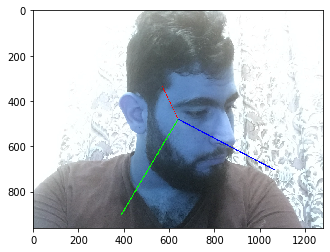

In [226]:
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin

plt.imshow(draw_axis(img_org, float(round(expectation_yaw.asnumpy()[0], 3)), float(round(expectation_pitch.asnumpy()[0], 3)), float(round(expectation_roll.asnumpy()[0], 3))))

In [175]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 500):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [247]:
20

20